# Label Frames & Train Frame Classifier

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook allows you to label the individual frames in a video from which a classifier in the sklearn library can be trained.

Notebook exports: labelled frames in a csv file and trained models in a joblib file.

## TOC:
0. [Import Libraries & Setup Helper Functions](#0.-Import-Libraries-&-Setup)
1. [Labeller](#1.-Detect-Pose-&-Label)
2. [Train & Evaluate Models](#2.-Train-&-Evaluate-Models)

# 0. Import Libraries & Setup

In [2]:
folder_name = 'squat-videos'
output_input_csv_filename = 'squat-labelled-frames.csv'

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score ,f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier

import pickle
from joblib import dump, load

import cv2
import mediapipe as mp

import os

In [3]:
all_landmarks = [] # List of dictionaries storing all the landmarks

def label_landmarks(landmarks, label):
    unboxed_landmarks = {}
    unboxed_landmarks['label'] = label # Label of the keypoint's coordinates
    
    # Store all the keypoint's x0,y0,z0...z32 coordinates in dictionary
    for i in range(33):
        unboxed_landmarks['x' + str(i)] = landmarks.landmark[i].x
        unboxed_landmarks['y' + str(i)] = landmarks.landmark[i].y
        unboxed_landmarks['z' + str(i)] = landmarks.landmark[i].z
        
    all_landmarks.append(unboxed_landmarks)

# 1. Detect Pose & Label

The code below is used to label frames in all the videos in a folder. First we find the training set and set aside the test set in the evaluation.

- Press 'p' to label a frame as not being parallel
- Press 'l' to label a frame as leaning forwards
- Press 'g' to label a frame as being good

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

directory = os.fsencode(folder_name)

all_videos = []

for file in os.listdir(directory):
    all_videos.append(os.fsdecode(file))
    
# Filenames of the videos we want to train the frame labeller on
# The test set is in f1-gen-heuristic notebook, same seed is used so same train and test set is created
train_videos, _, _, _ = train_test_split(all_videos, all_videos, test_size=0.33, random_state=42)

exit = False

for filename in train_videos:
    cap = cv2.VideoCapture(folder_name + '/' + filename)
    with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:

        while cap.isOpened():
            ret, image = cap.read()

            if ret == False:
                break
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            cv2.rectangle(image, (0,0), (225, 100), (0,0,0), -1)

            k = cv2.waitKey(1)
            
            if results.pose_landmarks is not None:      
                # Press 'p' to label a squat not parallel
                if k == 112:
                    label_landmarks(results.pose_landmarks, 'parallel')
                    cv2.putText(image, 'parallel', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

                # Press 'l' to label as a squat as leaning forwards
                if k == 108:
                    label_landmarks(results.pose_landmarks, 'leaning')
                    cv2.putText(image, 'leaning', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

                # Press 'g' to label a squat as good
                if k == 103:
                    label_landmarks(results.pose_landmarks, 'good')
                    cv2.putText(image, 'good', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
            
            # Press ESC to quit
            if k == 27:
                exit = True
                break

            cv2.namedWindow('output', cv2.WINDOW_NORMAL) # Allows you to manually change the size of the window
            cv2.imshow('output', image)

        cap.release()
        cv2.destroyAllWindows()
        if exit == True:
            break

In [ ]:
# Save the data in a csv
landmarks_df = pd.DataFrame(all_landmarks)
landmarks_df.to_csv(output_input_csv_filename, index=False)

In [4]:
# Read the data from a csv
landmarks_df = pd.read_csv(output_input_csv_filename)
landmarks_df

,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
0,parallel,0.302003,0.328756,-0.043625,0.310346,0.316614,-0.088935,0.314571,0.316048,-0.088872,...,-0.372342,0.566787,0.756253,0.403586,0.423825,0.803852,-0.449865,0.451938,0.764280,0.385692
1,parallel,0.302609,0.306816,-0.061167,0.311949,0.291499,-0.107550,0.316124,0.290599,-0.107514,...,-0.359367,0.570394,0.758656,0.394922,0.421607,0.802737,-0.446984,0.454325,0.763590,0.360563
2,parallel,0.311642,0.282741,-0.071476,0.317503,0.266856,-0.116231,0.321861,0.265913,-0.116238,...,-0.364201,0.569029,0.755586,0.355631,0.422840,0.803750,-0.475669,0.450945,0.760925,0.323066
3,parallel,0.313323,0.256082,-0.041410,0.320568,0.241338,-0.087059,0.325011,0.240360,-0.087099,...,-0.298777,0.563130,0.759676,0.293149,0.422651,0.803255,-0.420608,0.444162,0.762202,0.226731
4,parallel,0.325328,0.226877,-0.077686,0.336829,0.211829,-0.120044,0.341546,0.210645,-0.120140,...,-0.232965,0.566158,0.763903,0.316762,0.425461,0.802660,-0.425831,0.443933,0.765620,0.232855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,parallel,0.315575,0.291396,-0.051486,0.318320,0.278352,-0.120511,0.322200,0.277785,-0.120469,...,-0.281613,0.495020,0.770941,0.846306,0.311189,0.874485,-0.335067,0.382404,0.790527,0.921233
240,parallel,0.308004,0.200367,-0.075418,0.304277,0.186930,-0.142470,0.304163,0.187270,-0.142519,...,-0.243932,0.456334,0.794600,0.532433,0.310836,0.875065,-0.372815,0.325058,0.812239,0.498882
241,leaning,0.241831,0.611984,-0.071527,0.222016,0.605747,-0.116979,0.222655,0.603174,-0.116980,...,0.070809,0.522412,0.811468,0.411639,0.395277,0.869136,0.137486,0.395754,0.850129,0.450412
242,leaning,0.248447,0.621890,-0.051853,0.224587,0.615824,-0.095894,0.225106,0.613091,-0.095890,...,-0.070261,0.514665,0.800310,0.604635,0.396144,0.870922,-0.041493,0.412372,0.836483,0.646065


# 2. Train & Evaluate Models

In [5]:
model_scores = [] # Used for comparing different model's scores

def evaluate_model(model_name, prediction, display_matrix=False):
    acc = metrics.accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')

    model_metrics = {'Classifier': model_name, 
                     'Accuracy': acc, 
                     'Precision': precision, 
                     'Recall': recall,
                     'F1 Score': f1}

    if display_matrix:
        labels= ['parallel', 'leaning', 'good']
        cm = confusion_matrix(y_test, prediction, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.title(model_name)
        plt.show()
    
    return model_metrics

## Feature Extraction

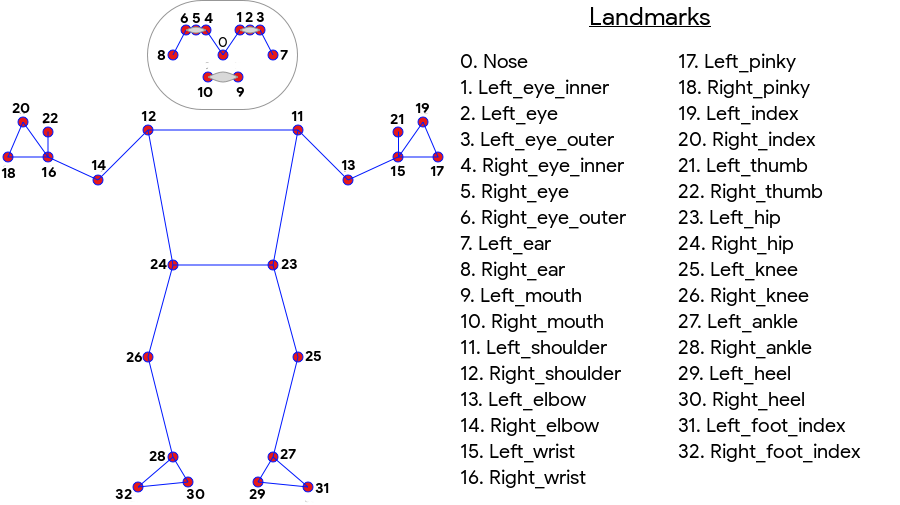

In [6]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [7]:
# Get the y differnece between two keypoints in a frame
# INPUT: frame (dictionary of keypoints to coordinates) and the 2 keypoints
# OUPUT: absolute value of the difference
def get_y_difference(frame, keypoint_1, keypoint_2):
    return abs(frame['y'+str(keypoint_1)] - frame['y'+str(keypoint_2)])

In [8]:
landmarks_df['hip_angle'] = landmarks_df.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
landmarks_df['knee_hip_difference'] = landmarks_df.apply(lambda row: get_y_difference(row, 23, 25), axis=1)
landmarks_df['knee_angle'] = landmarks_df.apply(lambda row: get_angle(row, 23, 25, 27), axis=1)

In [9]:
landmarks_df.head()

,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z30,x31,y31,z31,x32,y32,z32,hip_angle,knee_hip_difference,knee_angle
0,parallel,0.302003,0.328756,-0.043625,0.310346,0.316614,-0.088935,0.314571,0.316048,-0.088872,...,0.403586,0.423825,0.803852,-0.449865,0.451938,0.764280,0.385692,71.526169,0.104457,70.241432
1,parallel,0.302609,0.306816,-0.061167,0.311949,0.291499,-0.107550,0.316124,0.290599,-0.107514,...,0.394922,0.421607,0.802737,-0.446984,0.454325,0.763590,0.360563,80.099176,0.117568,77.497390
2,parallel,0.311642,0.282741,-0.071476,0.317503,0.266856,-0.116231,0.321861,0.265913,-0.116238,...,0.355631,0.422840,0.803750,-0.475669,0.450945,0.760925,0.323066,89.391170,0.127391,86.876530
3,parallel,0.313323,0.256082,-0.041410,0.320568,0.241338,-0.087059,0.325011,0.240360,-0.087099,...,0.293149,0.422651,0.803255,-0.420608,0.444162,0.762202,0.226731,102.834834,0.142559,106.495698
4,parallel,0.325328,0.226877,-0.077686,0.336829,0.211829,-0.120044,0.341546,0.210645,-0.120140,...,0.316762,0.425461,0.802660,-0.425831,0.443933,0.765620,0.232855,133.077513,0.156756,139.795349


In [10]:
landmarks_df = landmarks_df.filter(['hip_angle', 'knee_hip_difference', 'knee_angle', 'label'])

# Setup the testing and training sets
X = landmarks_df.drop('label', axis=1)
y = landmarks_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(163, 3) (163,) (81, 3) (81,)


In [11]:
landmarks_df.head()

,hip_angle,knee_hip_difference,knee_angle,label
0,71.526169,0.104457,70.241432,parallel
1,80.099176,0.117568,77.497390,parallel
2,89.391170,0.127391,86.876530,parallel
3,102.834834,0.142559,106.495698,parallel
4,133.077513,0.156756,139.795349,parallel


## Models

### Linear SVC

C:\Users\abid5.000\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


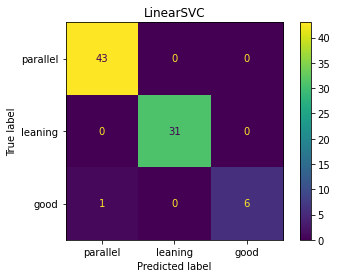

{'Classifier': 'LinearSVC', 'Accuracy': 0.9876543209876543, 'Precision': 0.9924242424242425, 'Recall': 0.9523809523809524, 'F1 Score': 0.9876543209876543}


In [12]:
svc_model = LinearSVC(random_state=1).fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

scores = evaluate_model('LinearSVC', y_pred, True)
model_scores.append(scores)
print(scores)

In [13]:
dump(svc_model, 'svc-squat-mistakes.joblib') # Export model

['svc-squat-mistakes.joblib']

### K-Nearest Neighbours

In [14]:
# Find K value with lowest error
error_rate = []
for i in range(1,35):
    pred_i = KNeighborsClassifier(n_neighbors=i).fit(X_train,y_train).predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

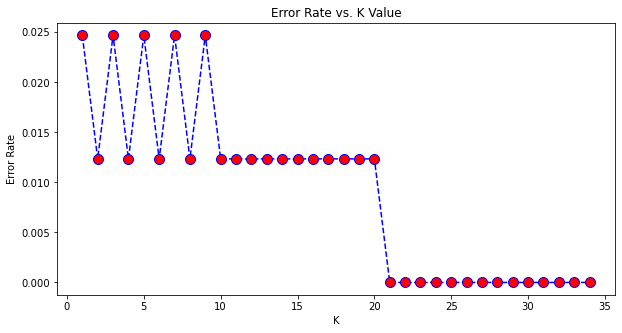

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(1,35),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

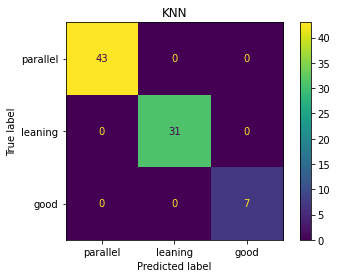

{'Classifier': 'KNN', 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


In [16]:
knc_model = KNeighborsClassifier(25).fit(X_train, y_train)
y_pred = knc_model.predict(X_test)
scores = evaluate_model('KNN', y_pred, True)
model_scores.append(scores)
print(scores)

In [17]:
dump(knc_model, 'knc-squat-mistakes.joblib') # Export model

['knc-squat-mistakes.joblib']

### Neural Network

C:\Users\abid5.000\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


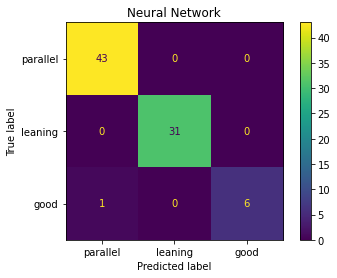

{'Classifier': 'Neural Network', 'Accuracy': 0.9876543209876543, 'Precision': 0.9924242424242425, 'Recall': 0.9523809523809524, 'F1 Score': 0.9876543209876543}


In [18]:
mlp_clf = MLPClassifier(activation='relu',
                        learning_rate='adaptive',
                        hidden_layer_sizes=(100),
                        learning_rate_init=0.01,
                        random_state=1)

y_pred = mlp_clf.fit(X_train, y_train).predict(X_test)
scores = evaluate_model('Neural Network', y_pred, True)
model_scores.append(scores)
print(scores)

In [20]:
dump(mlp_clf, 'mlp-squat-mistakes.joblib') # Export model

['mlp-squat-mistakes.joblib']

### Naive Bayes

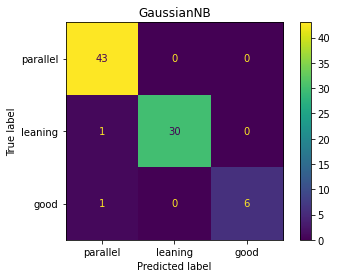

{'Classifier': 'GaussianNB', 'Accuracy': 0.9753086419753086, 'Precision': 0.9851851851851853, 'Recall': 0.9416282642089094, 'F1 Score': 0.9753086419753086}


In [21]:
gnb_model = GaussianNB()
y_pred = gnb_model.fit(X_train, y_train).predict(X_test)

scores = evaluate_model('GaussianNB', y_pred, True)
model_scores.append(scores)
print(scores)

In [22]:
dump(gnb_model, 'gnb-squat-mistakes.joblib') # Export model

['gnb-squat-mistakes.joblib']

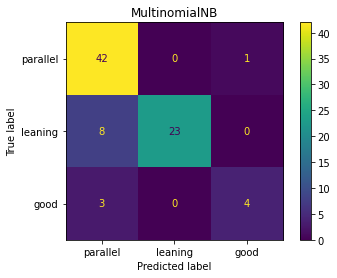

{'Classifier': 'MultinomialNB', 'Accuracy': 0.8518518518518519, 'Precision': 0.8641509433962264, 'Recall': 0.763369413782017, 'F1 Score': 0.8518518518518519}


In [23]:
mnb_model = MultinomialNB()
y_pred = mnb_model.fit(X_train, y_train).predict(X_test)

scores = evaluate_model('MultinomialNB', y_pred, True)
model_scores.append(scores)
print(scores)

In [24]:
dump(mnb_model, 'mnb-squat-mistakes.joblib') # Export model

['mnb-squat-mistakes.joblib']

## Best Performers

In [25]:
eval_scores = pd.DataFrame(model_scores)
eval_scores = eval_scores.sort_values(by = ['F1 Score'], ascending = False)
eval_scores

,Classifier,Accuracy,Precision,Recall,F1 Score
1,KNN,1.000000,1.000000,1.000000,1.000000
0,LinearSVC,0.987654,0.992424,0.952381,0.987654
2,Neural Network,0.987654,0.992424,0.952381,0.987654
3,GaussianNB,0.975309,0.985185,0.941628,0.975309
4,MultinomialNB,0.851852,0.864151,0.763369,0.851852


To see how the classifiers perform on all the videos go to the f1-gen-frame notebook for results.